## Project 1

### Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Access the metadata file from https://capitalmarkets.fanniemae.com/resources/file/credit-risk/xls/crt-file-layout-and-glossary.xlsx, save it to Google Drive, and read it as an Excel file. Extract the column names from the file to apply them to the Parquet file.

In [ ]:
import pandas as pd
metadata_file_path = "/content/drive/MyDrive/crt-file-layout-and-glossary_0.xlsx"
metadata = pd.read_excel(metadata_file_path)
column_names = metadata["Field Name"].dropna().astype(str).tolist()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Project1") \
    .getOrCreate()

parquet_folder_path = "/content/drive/MyDrive/dataset_parquet"

df = spark.read.parquet(parquet_folder_path)
df = df.toDF(*column_names)

df.head()

Row(Reference Pool ID=None, Loan Identifier=771399385783, Monthly Reporting Period=82000, Channel='R', Seller Name='Other', Servicer Name=None, Master Servicer=None, Original Interest Rate=7.625, Current Interest Rate=7.625, Original UPB=50000.0, UPB at Issuance=None, Current Actual UPB=0.0, Original Loan Term=180, Origination Date=121999, First Payment Date=22000, Loan Age=7, Remaining Months to Legal Maturity=173, Remaining Months To Maturity=162, Maturity Date=12015, Original Loan to Value Ratio (LTV)=75, Original Combined Loan to Value Ratio (CLTV)=None, Number of Borrowers=2, Debt-To-Income (DTI)=21, Borrower Credit Score at Origination=812, Co-Borrower Credit Score at Origination=802, First Time Home Buyer Indicator='N', Loan Purpose ='P', Property Type='SF', Number of Units=1, Occupancy Status='S', Property State='CA', Metropolitan Statistical Area (MSA)=40140, Zip Code Short=923, Mortgage Insurance Percentage=None, Amortization Type='FRM', Prepayment Penalty Indicator='N', Inte

### Analysis 1: Comparing the Average FICO Across Two Years

For this analysis, compare the average FICO scores across two years using the following steps:

1. **Date Column**: I will use the `Origination Date` column (formatted as MMYYYY) to determine the relevant time periods.
2. **FICO Columns**: The comparison will be based on two columns:
   - `Borrower Credit Score at Origination`
   - `Co-Borrower Credit Score at Origination`



In [ ]:
from pyspark.sql.functions import col, substring, avg

df_fico = df.select(
    col("Origination Date").alias("origination_date"),
    col("Borrower Credit Score at Origination").cast("integer").alias("borrower_fico"),
    col("Co-Borrower Credit Score at Origination").cast("integer").alias("co_borrower_fico")
)

df_fico = df_fico.withColumn("year", substring("origination_date", -4, 4).cast("integer"))

average_fico = df_fico.groupBy("year").agg(
    avg("borrower_fico").alias("avg_borrower_fico"),
    avg("co_borrower_fico").alias("avg_co_borrower_fico")
)

average_fico.show()

+----+-----------------+--------------------+
|year|avg_borrower_fico|avg_co_borrower_fico|
+----+-----------------+--------------------+
|2000|709.3761423687233|   716.9005000544983|
|1999|710.8483665692045|   718.1592476668707|
+----+-----------------+--------------------+



### Analysis 2: Monthly Delinquency Rates and Variation by Loan Term

This analysis addresses two specific problems:  
a. **The monthly delinquency rates for 30, 60, and 90 days past due**  
b. **How these delinquency rates vary by loan term**

#### Analysis 2a: Monthly Delinquency Rates for 30, 60, and 90 Days Past Due  
This involves a straightforward process of bucketing, grouping, and joining data:  
1. **Columns Used**:  
   - `Monthly Reporting Period` (formatted as MMYYYY)  
   - `Current Loan Delinquency Status` (indicates the number of months since delinquency)  
 

In [ ]:
from pyspark.sql.functions import col, substring, count, length, when, expr

df_delin = (
    df
    .withColumn("period_len", length(col("Monthly Reporting Period")))
    .withColumn(
        "month_str",
        expr("substring(`Monthly Reporting Period`, 1, period_len - 4)")
    )
    .withColumn("month", col("month_str").cast("int"))
    .withColumn("year", substring(col("Monthly Reporting Period"), -4, 4).cast("int"))
    .drop("period_len", "month_str")
)

df_delin = df_delin.withColumn(
    "delinquency_category",
    when((col("Current Loan Delinquency Status") >= 30) & (col("Current Loan Delinquency Status") < 60), "30 Days")
    .when((col("Current Loan Delinquency Status") >= 60) & (col("Current Loan Delinquency Status") < 90), "60 Days")
    .when((col("Current Loan Delinquency Status") >= 90) & (col("Current Loan Delinquency Status") < 120), "90 Days")
    .otherwise("Other")
)

total_loans_df = df_delin.groupBy("year", "month").agg(count("*").alias("total_loans"))

delinquency_df = df_delin.groupBy("year", "month", "delinquency_category").agg(count("*").alias("delinquent_count"))

result = delinquency_df.join(total_loans_df, ["year", "month"]) \
    .withColumn("delinquency_rate", col("delinquent_count") / col("total_loans") * 100)

result_filtered = result.filter(col("delinquency_category").isin("30 Days", "60 Days", "90 Days"))

pandas_df_delin = result_filtered.orderBy("year", "month", "delinquency_category").toPandas()

pandas_df_delin

,year,month,delinquency_category,delinquent_count,total_loans,delinquency_rate
0,2002,8,30 Days,8,910256,0.000879
1,2002,9,30 Days,8,865624,0.000924
2,2002,10,30 Days,8,815632,0.000981
3,2002,11,30 Days,24,760160,0.003157
4,2002,12,30 Days,16,711544,0.002249
...,...,...,...,...,...,...
592,2024,1,90 Days,8,7712,0.103734
593,2024,2,60 Days,8,7608,0.105152
594,2024,2,90 Days,8,7608,0.105152
595,2024,3,60 Days,8,7544,0.106045


#### Analysis 2b: Delinquency Rates by Loan Term

In this analysis, instead of examining delinquency rates month/year-wise, the focus will be on how these rates vary by the `Original Loan Term`. The `Original Loan Term` is in months, and it will be grouped into the following yearly buckets:

- **Under 10 years** (less than 120 months)
- **10–14 years** (120–179 months)
- **15–19 years** (180–239 months)
- **20–24 years** (240–299 months)
- **25–29 years** (300–359 months)
- **30 years** (360 months)

In [ ]:
from pyspark.sql.functions import col, count, when

df_bucketed = df.withColumn(
    "loan_term_bucket",
    when(col("Original Loan Term") < 120, "Under 10 years")
    .when((col("Original Loan Term") >= 120) & (col("Original Loan Term") < 180), "10-14 years")
    .when((col("Original Loan Term") >= 180) & (col("Original Loan Term") < 240), "15-19 years")
    .when((col("Original Loan Term") >= 240) & (col("Original Loan Term") < 300), "20-24 years")
    .when((col("Original Loan Term") >= 300) & (col("Original Loan Term") < 360), "25-29 years")
    .when(col("Original Loan Term") == 360, "30 years")
    .otherwise("Other")
)

df_bucketed = df_bucketed.withColumn(
    "delinquency_category",
    when((col("Current Loan Delinquency Status") >= 30) & (col("Current Loan Delinquency Status") < 60), "30 Days")
    .when((col("Current Loan Delinquency Status") >= 60) & (col("Current Loan Delinquency Status") < 90), "60 Days")
    .when((col("Current Loan Delinquency Status") >= 90) & (col("Current Loan Delinquency Status") < 120), "90 Days")
    .otherwise("Other")
)

total_loans_df = df_bucketed.groupBy("loan_term_bucket").agg(count("*").alias("total_loans"))

delinquency_df = df_bucketed.groupBy("loan_term_bucket", "delinquency_category").agg(count("*").alias("delinquent_count"))

result = delinquency_df.join(total_loans_df, ["loan_term_bucket"]).withColumn(
    "delinquency_rate", col("delinquent_count") / col("total_loans") * 100
)

result_filtered = result.filter(col("delinquency_category").isin("30 Days", "60 Days", "90 Days"))

pandas_df = result_filtered.orderBy("loan_term_bucket", "delinquency_category").toPandas()
pandas_df


,loan_term_bucket,delinquency_category,delinquent_count,total_loans,delinquency_rate
0,10-14 years,30 Days,384,1038704,0.036969
1,10-14 years,60 Days,248,1038704,0.023876
2,15-19 years,30 Days,5472,13507224,0.040512
3,15-19 years,60 Days,448,13507224,0.003317
4,15-19 years,90 Days,344,13507224,0.002547
5,20-24 years,30 Days,2824,2284048,0.123640
6,20-24 years,60 Days,576,2284048,0.025218
7,20-24 years,90 Days,368,2284048,0.016112
8,25-29 years,30 Days,808,639944,0.126261
9,25-29 years,60 Days,16,639944,0.002500


### Analysis 3: Categorizing FICO Scores and Visualizing Credit Scores for First-Time Buyers

In this analysis, FICO scores will be categorized into the following ranges:  

- **Poor**: [300, 579]  
- **Fair**: [580, 669]  
- **Good**: [670, 739]  
- **Very Good**: [740, 799]  
- **Excellent**: [800, 850] 

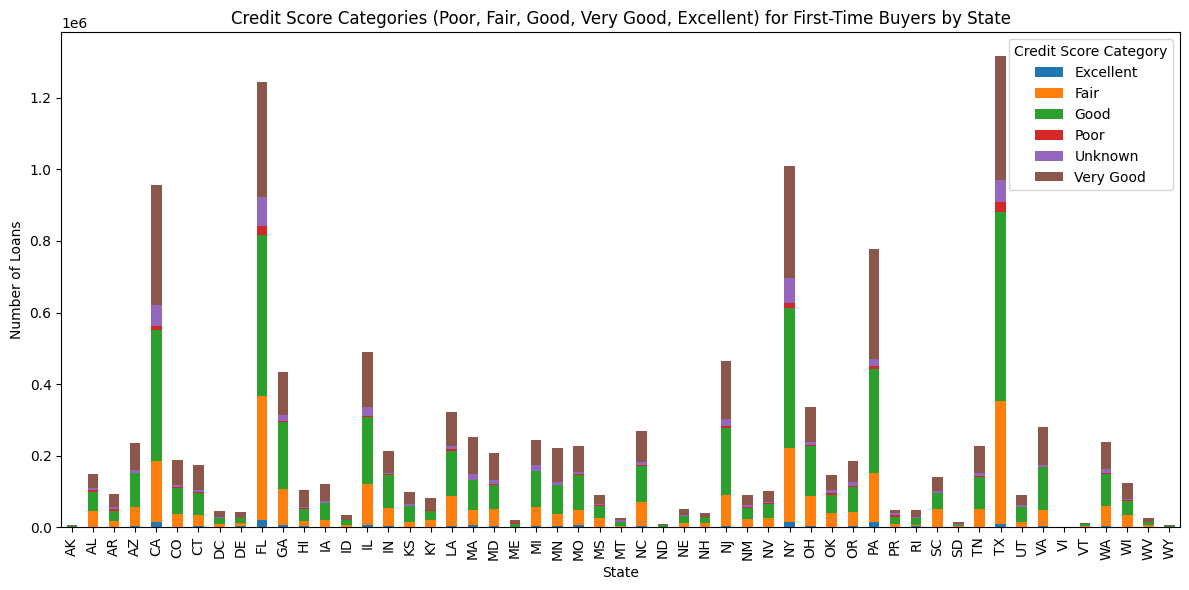

In [ ]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

df_filtered = df.filter(col("First Time Home Buyer Indicator") == "Y")

df_categorized = df_filtered.withColumn(
    "credit_score_category",
    when(col("Borrower Credit Score at Origination") < 580, "Poor")
    .when((col("Borrower Credit Score at Origination") >= 580) & (col("Borrower Credit Score at Origination") < 670), "Fair")
    .when((col("Borrower Credit Score at Origination") >= 670) & (col("Borrower Credit Score at Origination") < 740), "Good")
    .when((col("Borrower Credit Score at Origination") >= 740) & (col("Borrower Credit Score at Origination") < 800), "Very Good")
    .when(col("Borrower Credit Score at Origination") >= 800, "Excellent")
    .otherwise("Unknown")
)

grouped_df = (
    df_categorized
    .groupBy("Property State", "credit_score_category")
    .count()
    .withColumnRenamed("count", "num_loans")
)

pandas_df = grouped_df.toPandas()

pivot_df = pandas_df.pivot(index="Property State", columns="credit_score_category", values="num_loans").fillna(0)


pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Credit Score Categories (Poor, Fair, Good, Very Good, Excellent) for First-Time Buyers by State"
)

plt.xlabel("State")
plt.ylabel("Number of Loans")
plt.legend(title="Credit Score Category")
plt.tight_layout()
plt.show()



### Analysis 4: Analyzing Correlations Between FICO Score, LTV Ratio, Interest Rate, and Loan Status

In this analysis, we will explore the relationships between the **FICO Score**, **LTV Ratio**, and **Interest Rate** with the **Loan Status**. The loan status is represented by the `Zero Balance Code`, which can be mapped using the `crt-file-layout-and-glossary_0.xlsx`.

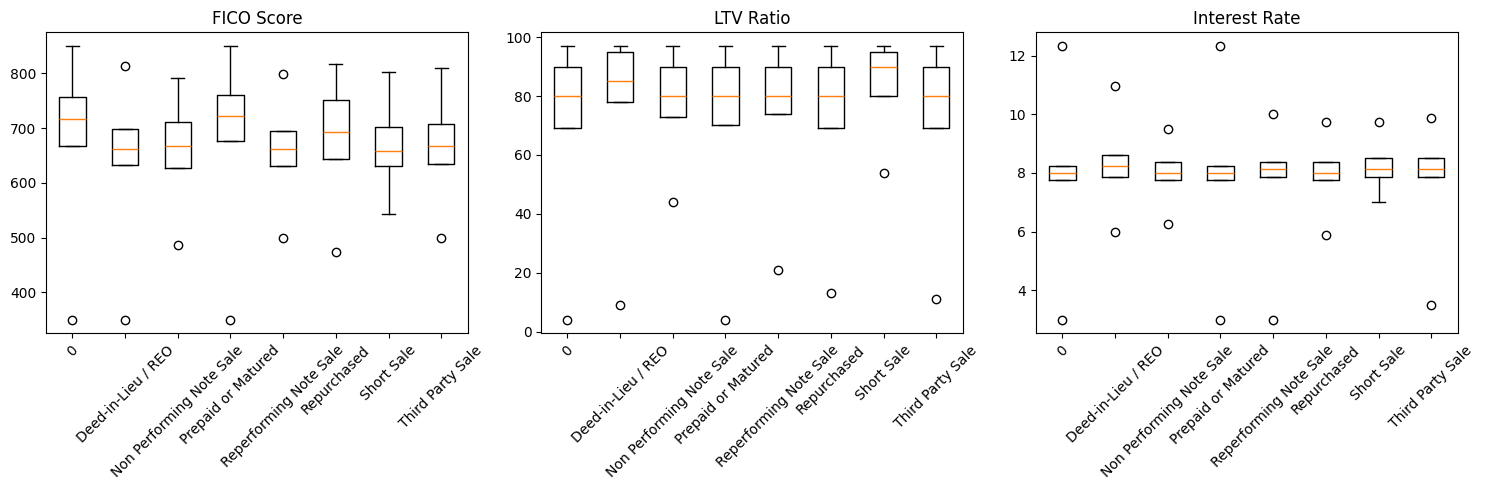

In [ ]:
from pyspark.sql.functions import create_map, lit, col, expr
import matplotlib.pyplot as plt

zbc_mapping = create_map(
    [
        lit("1"), lit("Prepaid or Matured"),
        lit("2"), lit("Third Party Sale"),
        lit("3"), lit("Short Sale"),
        lit("6"), lit("Repurchased"),
        lit("9"), lit("Deed-in-Lieu / REO"),
        lit("15"), lit("Non Performing Note Sale"),
        lit("16"), lit("Reperforming Note Sale"),
        lit("96"), lit("Removal")
    ]
)

df_mapped = (
    df.withColumn("zbc_label", zbc_mapping[col("Zero Balance Code")])
      .withColumn("fico_score", col("Borrower Credit Score at Origination").cast("double"))
      .withColumn("ltv_ratio", col("Original Loan to Value Ratio (LTV)").cast("double"))
      .withColumn("interest_rate", col("Original Interest Rate").cast("double"))
)

quantiles_df = (
    df_mapped.groupBy("zbc_label")
    .agg(
        expr("percentile_approx(fico_score, 0.0, 100) as fico_min"),
        expr("percentile_approx(fico_score, 0.25, 100) as fico_q1"),
        expr("percentile_approx(fico_score, 0.5, 100) as fico_median"),
        expr("percentile_approx(fico_score, 0.75, 100) as fico_q3"),
        expr("percentile_approx(fico_score, 1.0, 100) as fico_max"),

        expr("percentile_approx(ltv_ratio, 0.0, 100) as ltv_min"),
        expr("percentile_approx(ltv_ratio, 0.25, 100) as ltv_q1"),
        expr("percentile_approx(ltv_ratio, 0.5, 100) as ltv_median"),
        expr("percentile_approx(ltv_ratio, 0.75, 100) as ltv_q3"),
        expr("percentile_approx(ltv_ratio, 1.0, 100) as ltv_max"),

        expr("percentile_approx(interest_rate, 0.0, 100) as ir_min"),
        expr("percentile_approx(interest_rate, 0.25, 100) as ir_q1"),
        expr("percentile_approx(interest_rate, 0.5, 100) as ir_median"),
        expr("percentile_approx(interest_rate, 0.75, 100) as ir_q3"),
        expr("percentile_approx(interest_rate, 1.0, 100) as ir_max")
    )
    .orderBy("zbc_label")
)

pdf = quantiles_df.toPandas().fillna(0)
labels = pdf["zbc_label"].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, prefix, title in zip(
    axes,
    ["fico", "ltv", "ir"],
    ["FICO Score", "LTV Ratio", "Interest Rate"]
):
    box_data = []
    for _, row in pdf.iterrows():
        box_data.append([
            row[f"{prefix}_min"],
            row[f"{prefix}_q1"],
            row[f"{prefix}_median"],
            row[f"{prefix}_q3"],
            row[f"{prefix}_max"]
        ])
    ax.boxplot(box_data, labels=labels, showmeans=False)
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


### Analysis 5: Assessing Default Risk and Comparison Over Time

To analyze default risk, there is two options:
1. **Current Loan Delinquency Status**: Identifying loans delinquent for more than 90 days.
2. **Zero Balance Code**: Using specific codes (2, 3, 6, 9, 15, and 16) to track loans that have left the pool due to default.
   

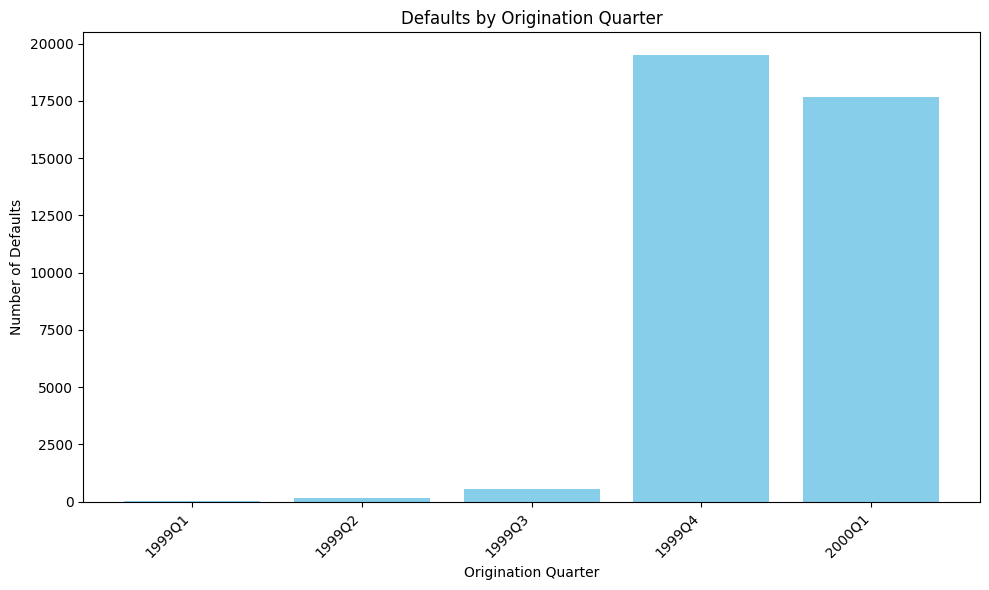

In [ ]:
from pyspark.sql.functions import (
    col, substring, when, count, sum as _sum,
    length, expr
)
import matplotlib.pyplot as plt
import numpy as np

df_default = (
    df
    .withColumn("period_len", length(col("Origination Date")))
    .withColumn(
        "month_str",
        expr("substring(`Origination Date`, 1, period_len - 4)")
    )
    .withColumn("origination_month", col("month_str").cast("int"))
    .withColumn("origination_year", substring(col("Origination Date"), -4, 4).cast("int"))
    .withColumn("origination_quarter", ((col("origination_month") - 1) / 3).cast("int") + 1)
    .drop("period_len", "month_str")
)

df_default = df_default.withColumn(
    "default_flag",
    when(col("Zero Balance Code").isin("2", "3", "6", "9", "15", "16"), 1).otherwise(0)
)

result_default = (
    df_default.groupBy("origination_year", "origination_quarter")
      .agg(_sum("default_flag").alias("total_defaults"))
)

pdf = result_default.toPandas()

pdf["origination_year"] = pdf["origination_year"].fillna(0).astype(int)
pdf["origination_quarter"] = pdf["origination_quarter"].fillna(0).astype(int)

pdf = pdf.sort_values(["origination_year", "origination_quarter"])

pdf["label"] = pdf["origination_year"].astype(str) + "Q" + pdf["origination_quarter"].astype(str)
labels = pdf["label"].tolist()
defaults = pdf["total_defaults"].tolist()


plt.figure(figsize=(10, 6))
plt.bar(labels, defaults, color="skyblue")
plt.xlabel("Origination Quarter")
plt.ylabel("Number of Defaults")
plt.title("Defaults by Origination Quarter")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Analysis 7: Recovery Rate After Default

This analysis is to calculate the loan amount recovered and the amount left:

1. **Amount Left**: This is obtained from the `UPB at the Time of Removal` column.
2. **Amount Recovered**: To calculate the amount recovered, sum the following columns:
   - `Net Sales Proceeds`
   - `Credit Enhancement Proceeds`
   - `Repurchase Make Whole Proceeds`
   - `Other Foreclosure Proceeds`  

**Recovery rate is amount_recovered / UPB at the Time of Removal.**
 

In [ ]:
from pyspark.sql.functions import col, when, sum as _sum, avg

df_defaulted = df.withColumn(
    "default_flag",
    when(col("Zero Balance Code").isin("2", "3", "6", "9", "15", "16"), 1).otherwise(0)
)

df_defaulted = df_defaulted.filter(col("default_flag") == 1)

df_recovery = df_defaulted.withColumn(
    "amount_recovered",
    (
        col("Net Sales Proceeds").cast("double")
        + col("Credit Enhancement Proceeds").cast("double")
        + col("Repurchase Make Whole Proceeds").cast("double")
        + col("Other Foreclosure Proceeds").cast("double")
    )
)

df_recovery = df_recovery.withColumn(
    "recovery_rate",
    (col("amount_recovered") / col("UPB at the Time of Removal").cast("double")) * 100
)

result = df_recovery.agg(avg("recovery_rate").alias("avg_recovery_rate"))
result.toPandas()


,avg_recovery_rate
0,99.523876


### Analysis 8: Property Price Changes Over Time

This analysis calculates and plots the **average**, **median**, and **variance** of property price changes over the entire loan duration, bucketed by month.

**Property Price Change Calculation**: Since the `Original List Price` and `Current List Price` columns are empty, **`Original UPB`** is used as a proxy, representing the original loan balance, which serves as a reasonable stand-in for the property price.


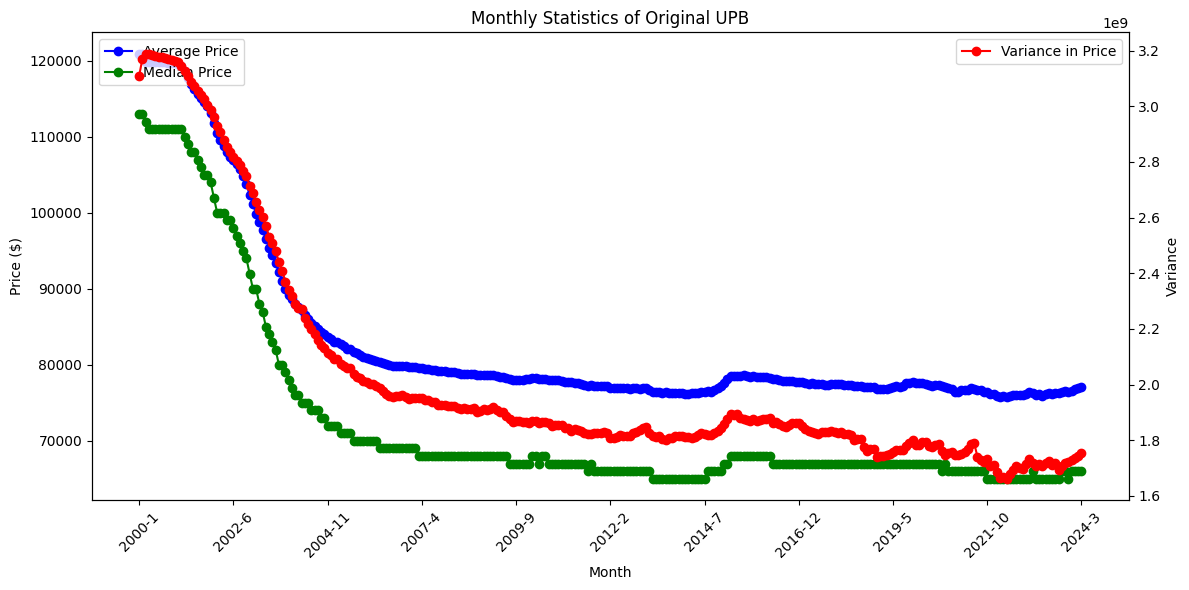

In [ ]:
from pyspark.sql.functions import avg, variance, percentile_approx, expr, substring, length
import matplotlib.pyplot as plt

df_monthly = (
    df
    .withColumn("period_len", length(col("Monthly Reporting Period")))
    .withColumn("month", expr("substring(`Monthly Reporting Period`, 1, period_len - 4)").cast("int"))
    .withColumn("year", substring("Monthly Reporting Period", -4, 4).cast("int"))
    .drop("period_len")
)

monthly_stats = (
    df_monthly.groupBy("year", "month")
    .agg(
        avg("Original UPB").alias("avg_price"),
        percentile_approx("Original UPB", 0.5).alias("median_price"),
        variance("Original UPB").alias("variance_price")
    )
    .orderBy("year", "month")
)

pdf_monthly_stats = monthly_stats.toPandas()
pdf_monthly_stats["period"] = pdf_monthly_stats["year"].astype(str) + "-" + pdf_monthly_stats["month"].astype(str)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(
    pdf_monthly_stats["period"], pdf_monthly_stats["avg_price"],
    label="Average Price", marker="o", color="blue"
)
ax1.plot(
    pdf_monthly_stats["period"], pdf_monthly_stats["median_price"],
    label="Median Price", marker="o", color="green"
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Price ($)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(
    pdf_monthly_stats["period"], pdf_monthly_stats["variance_price"],
    label="Variance in Price", marker="o", color="red"
)
ax2.set_ylabel("Variance")
ax2.legend(loc="upper right")

plt.xticks(range(0, len(pdf_monthly_stats), max(1, len(pdf_monthly_stats)//10)),
           pdf_monthly_stats["period"].iloc[::max(1, len(pdf_monthly_stats)//10)], rotation=45)

plt.title("Monthly Statistics of Original UPB")
plt.tight_layout()
plt.show()


In [ ]:
spark.stop()